In [1]:
# !pip install pyspark

In [20]:
from pyspark.sql import SparkSession
import numpy as np
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# Run this cell if running locally

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# Run this cell for SDSC at 60 gb per node, 30 cores. 

# spark = SparkSession.builder\
#     .config("spark.driver.memory", "4g")\
#     .config("spark.executor.memory", "4g")\
#     .config("spark.executor.instances", 14)\
#     .getOrCreate()

In [5]:
spark

In [6]:
# Load CSV into Spark DataFrame

# Cluster Directory: "/home/kphan/kphan/data/all_reviews/all_reviews.csv"
# dir = "/home/kphan/kphan/data/all_reviews/all_reviews.csv"

dir = "resources/data/all_reviews_100000_sample.csv"
df = spark.read.csv(dir, header=True, inferSchema=True)

# Show df
df.show()

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-------------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played| language|                               review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-------+--------------------+-----------------+---------------

In [7]:
# List out the columns for ease of view
print(f"Columns in Original Dataframe:\n\n{df.columns}\n")

df.summary().show()


Columns in Original Dataframe:

['recommendationid', 'appid', 'game', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'hidden_in_steam_china', 'steam_china_location']

+-------+---------------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+-----------------------+------------------------------+-------------------------+--------------------+------------------+--------------------+--------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+-------------------------------------+--------------------

## Initial Data Cleanup / Feature Engineering

In [8]:
# Convert column to float
df = df.withColumn("weighted_vote_score", F.col("weighted_vote_score").cast("float"))

# Then filter
df_cleaned = df.filter(F.col("weighted_vote_score") != 0)
df_cleaned.show(10)

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-------------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|                               review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-------+--------------------+-----------------+-----------------

In [9]:
# Drop multiple columns not being used for study

# Dropping review column as content will not be evaluated (not exploring NLP in this case)
df_cleaned = df_cleaned.drop("steam_china_location", "hidden_in_steam_china", "review")

# Show the updated DataFrame
df_cleaned.show(10)

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-----------------+----------

In [10]:
# Converting author playtime to hours
df_cleaned = (
    df_cleaned
    .withColumn("author_playtime_forever", F.col("author_playtime_forever").cast("float") / 60)
    .withColumn("author_playtime_at_review", F.col("author_playtime_at_review").cast("float") / 60)
)

df_cleaned.show()

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played| language|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-----------------+-------

In [11]:
### Not necessary just thought it would make playtime cleaner ###

# Round playtime to whole number

df_cleaned = (
    df_cleaned
    .withColumn("author_playtime_forever", F.round(F.col("author_playtime_forever"), 0))
    .withColumn("author_playtime_at_review", F.round(F.col("author_playtime_at_review"), 0))
)

df_cleaned.show()

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played| language|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-----------------+-------

In [12]:
# Removing any duplicates (and counting) - long/expensive operation

before = df_cleaned.count()
df_cleaned = df_cleaned.dropDuplicates()
after =df_cleaned.count()

print(f"Count of rows before: {before}\nCount of rows after: {after}")

Count of rows before: 33957
Count of rows after: 33957


In [13]:
# Bar graph which games have the most play time (of reviews)

# Looking to represent playtime statistics for each game

total_playtimes = (
    df_cleaned.groupBy("game")
    .agg(F.sum("author_playtime_at_review").alias("Total Reviewer Playtime (At time of review)"), F.count("*").alias("Review Count"))
    .withColumn("Average Playtime Per Review", F.round(F.col("Total Reviewer Playtime (At time of review)") / F.col("Review Count")))
)

total_playtimes.show()

+--------------------+-------------------------------------------+------------+---------------------------+
|                game|Total Reviewer Playtime (At time of review)|Review Count|Average Playtime Per Review|
+--------------------+-------------------------------------------+------------+---------------------------+
|Business Tour - O...|                                      223.0|          17|                       13.0|
|     Hogwarts Legacy|                                     1337.0|          35|                       38.0|
|The Elder Scrolls...|                                    16812.0|          93|                      181.0|
|DRAGON BALL FighterZ|                                     1989.0|          21|                       95.0|
|       Making Lovers|                                        6.0|           1|                        6.0|
|             Coromon|                                       24.0|           3|                        8.0|
|MachineCraft premium|      

In [14]:
# Conversion of aggregated table to Pandas for visualization
top_10_reviewer_playtimes_df = total_playtimes.orderBy(F.col("Total Reviewer Playtime (At time of review)").desc()).limit(10).toPandas()
top_10_review_count_df = total_playtimes.orderBy(F.col("Review Count").desc()).limit(10).toPandas()

In [15]:
top_10_reviewer_playtimes_df

,game,Total Reviewer Playtime (At time of review),Review Count,Average Playtime Per Review
0,Counter-Strike 2,1135037.0,2199,516.0
1,Rust,146627.0,302,486.0
2,Team Fortress 2,145873.0,283,515.0
3,PUBG: BATTLEGROUNDS,133623.0,505,265.0
4,Garry's Mod,110680.0,239,463.0
5,Tom Clancy's Rainbow Six Siege,94371.0,324,291.0
6,Dead by Daylight,79812.0,221,361.0
7,Warframe,77536.0,137,566.0
8,ARK: Survival Evolved,69683.0,200,348.0
9,Grand Theft Auto V,69061.0,379,182.0


In [16]:
top_10_review_count_df

,game,Total Reviewer Playtime (At time of review),Review Count,Average Playtime Per Review
0,Counter-Strike 2,1135037.0,2199,516.0
1,PUBG: BATTLEGROUNDS,133623.0,505,265.0
2,Grand Theft Auto V,69061.0,379,182.0
3,Tom Clancy's Rainbow Six Siege,94371.0,324,291.0
4,Rust,146627.0,302,486.0
5,Team Fortress 2,145873.0,283,515.0
6,Terraria,39127.0,269,145.0
7,Garry's Mod,110680.0,239,463.0
8,PAYDAY 2,27166.0,229,119.0
9,Dead by Daylight,79812.0,221,361.0


C:\Users\Khanh Phan\AppData\Local\Temp\ipykernel_35808\2796111726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Khanh Phan\AppData\Local\Temp\ipykernel_35808\2796111726.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


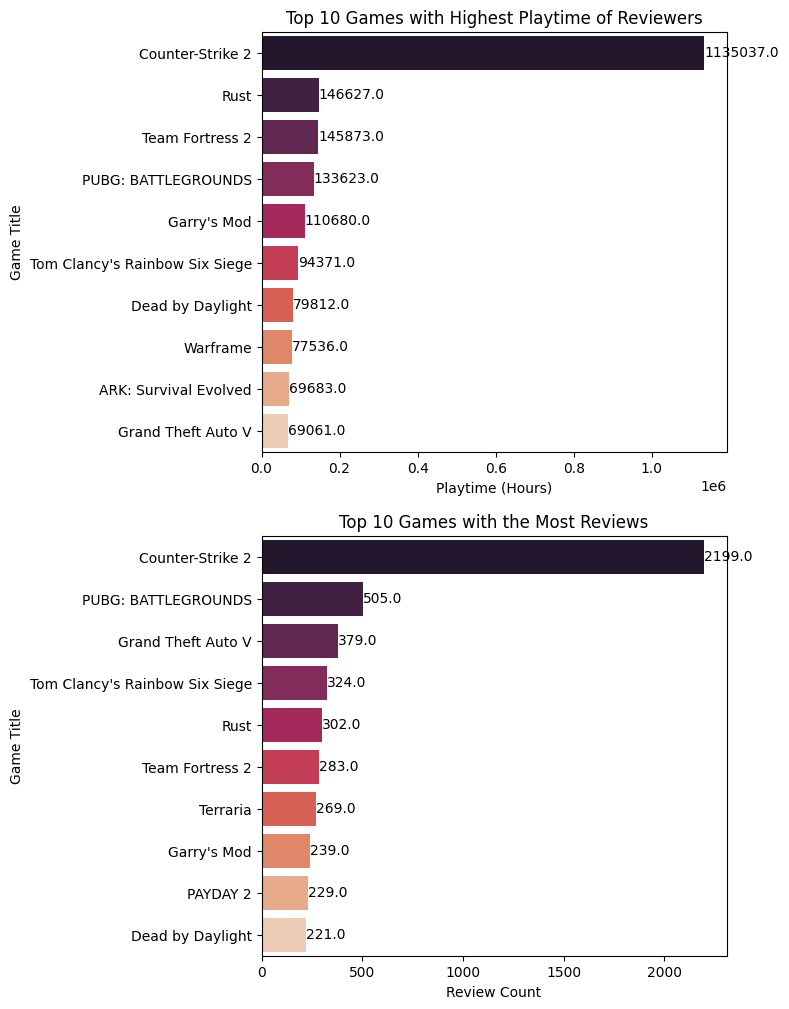

In [39]:
# Bargraph of top 10 games with the most total playtime per reviewer, top 10 games with most reviews
# Omitting stats on average playtime per review as would be skewed towards games with fewer reviews

fig, axes = plt.subplots(2,1,figsize = (6,12))

# Plot 1: Top 10 games with the most total playtime per reviewer
sns.barplot(
    y = top_10_reviewer_playtimes_df["game"],
    x = top_10_reviewer_playtimes_df["Total Reviewer Playtime (At time of review)"],
    ax = axes[0],
    palette = "rocket",
    orient = "h"
)
axes[0].set_title("Top 10 Games with Highest Playtime of Reviewers")
axes[0].set_ylabel("Game Title")
axes[0].set_xlabel("Playtime (Hours)")
for container in axes[0].containers:
  axes[0].bar_label(container, fmt='%.1f')

# Plot 2: Top 10 games with most reviews
sns.barplot(
    y = top_10_review_count_df["game"],
    x = top_10_review_count_df["Review Count"],
    ax = axes[1],
    palette = "rocket", 
    orient = "h"
)
axes[1].set_title("Top 10 Games with the Most Reviews")
axes[1].set_ylabel("Game Title")
axes[1].set_xlabel("Review Count")
for container in axes[1].containers:
  axes[1].bar_label(container, fmt='%.1f')

plt.show()